## DSC_Ania_s21845_Konrad_s32955

In [ ]:
# !pip install xgboost
# !pip install catboost

## ------------------------------------------------------------------------------------------
## Dwie pierwsze wersje
## ------------------------------------------------------------------------------------------

In [ ]:
# 1.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
# Przekształcenie zmiennych kategorycznych na wartości liczbowe (np. Marka_pojazdu: BMW → 0, Audi → 1).
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Wyposazenie"])
y = train_df["Cena"]

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Optymalizacja hiperparametrów XGBoost
param_grid = {
    'n_estimators': [500, 700],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 0.9]
}
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Trenowanie modelu XGBoost
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Trenowanie modelu CatBoost
cat = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.05, random_state=42, verbose=False)
cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Trenowanie modelu RandomForest
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)
y_pred_cat = cat.predict(X_val)
y_pred_rf = rf.predict(X_val)

# Ensemble Learning
# Cel: Uśrednienie wyników trzech modeli w celu uzyskania lepszej dokładności.s
final_pred = (y_pred_xgb + y_pred_cat + y_pred_rf) / 3

# Ocena modeli
print("RMSE XGBoost:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("RMSE CatBoost:", np.sqrt(mean_squared_error(y_val, y_pred_cat)))
print("RMSE RandomForest:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("RMSE Model Ensemble:", np.sqrt(mean_squared_error(y_val, final_pred)))

# Predykcja na zbiorze testowym
test_predictions = (best_xgb.predict(X_test) + cat.predict(X_test) + rf.predict(X_test)) / 3

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index,
    "Cena": test_predictions
})
submission.to_csv("submissionR1.csv", index=False)


Ocena wyników modeli na podstawie RMSE:
RMSE (Root Mean Squared Error) to metryka oceniająca błędy predykcji – im niższa wartość, tym lepsza jakość modelu.

Model	RMSE
XGBoost	16,510
CatBoost	19,066
RandomForest	20,750
Ensemble	17,956
Interpretacja wyników:
XGBoost osiąga najlepszy wynik (16,510 RMSE)
- Jest to najdokładniejszy model w zestawieniu.
- Wykorzystuje technikę boostingową, co pozwala mu dobrze dopasować się do danych.
- Prawdopodobnie dobrze radzi sobie z zależnościami nieliniowymi i optymalnie wykorzystuje cechy.

CatBoost ma wyższe RMSE (19,066)
- Może nie radzić sobie tak dobrze z danymi jak XGBoost.
- Być może lepsza optymalizacja hiperparametrów poprawiłaby wynik.
- CatBoost dobrze radzi sobie z danymi kategorycznymi, więc może poprawić wynik po lepszym przygotowaniu cech.

RandomForest ma najwyższe RMSE (20,750)
- Model może mieć trudności z uchwyceniem skomplikowanych zależności w danych.
- RandomForest działa dobrze na dużych zbiorach danych, ale może nie być najlepszy do regresji z bardzo różnorodnymi danymi.
- Jego wysoka wartość RMSE wskazuje, że może być mniej skuteczny w przewidywaniu cen samochodów.

Model Ensemble (RMSE: 17,956)
- Jest lepszy niż CatBoost i RandomForest, ale gorszy niż sam XGBoost.
- Uśrednianie predykcji może pomóc w stabilizacji wyników, ale jeśli jeden model znacząco przewyższa pozostałe, ensemble może nie przynieść dużej poprawy.
- Warto sprawdzić, czy eliminacja słabszych modeli (np. RandomForest) poprawi wynik.


WPROWADZONE KROKI KU ULEPSZENIU:
- Usunięto RandomForest – który miał najgorsze RMSE.
- Dodano transformację logarytmiczną dla Cena i Przebieg_km, aby poprawić stabilność modelu.
- Dostosowano hiperparametry XGBoost i CatBoost – zwiększona liczba iteracji, optymalna głębokość drzewa i niższy learning_rate.
- Ensemble Learning – teraz wykorzystuje tylko XGBoost i CatBoost.
- Poprawiona interpretacja predykcji – wyniki są konwertowane z powrotem z logarytmicznej skali (np.expm1()).

In [ ]:
# 2.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Transformacja logarytmiczna dla zmiennych liczbowych
train_df["Log_Cena"] = np.log1p(train_df["Cena"])
train_df["Log_Przebieg_km"] = np.log1p(train_df["Przebieg_km"])
test_df["Log_Przebieg_km"] = np.log1p(test_df["Przebieg_km"])

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Log_Cena", "Wyposazenie"])
y = train_df["Log_Cena"]

# Upewnienie się, że test_df zawiera wszystkie cechy z X
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Dodanie brakujących kolumn

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Trenowanie modelu XGBoost
best_xgb = XGBRegressor(n_estimators=700, learning_rate=0.01, max_depth=7, subsample=0.9, random_state=42)
best_xgb.fit(X_train, y_train)

# Trenowanie modelu CatBoost
cat = CatBoostRegressor(iterations=700, depth=7, learning_rate=0.01, random_state=42, verbose=False)
cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)
y_pred_cat = cat.predict(X_val)

# Ensemble Learning (bez RandomForest)
final_pred = (y_pred_xgb + y_pred_cat) / 2

# Ocena modeli
print("RMSE XGBoost:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("RMSE CatBoost:", np.sqrt(mean_squared_error(y_val, y_pred_cat)))
print("RMSE Model Ensemble:", np.sqrt(mean_squared_error(y_val, final_pred)))

# Predykcja na zbiorze testowym
test_predictions = np.expm1((best_xgb.predict(X_test) + cat.predict(X_test)) / 2)

# Tworzenie zgłoszenia z ID zaczynającym się od 1
submission = pd.DataFrame({
    "ID": test_df.index + 1,  # Zmiana indeksacji na 1-based
    "Cena": test_predictions
})
submission.to_csv("submissionR2.csv", index=False)


Ocena wyników modeli na podstawie RMSE:
Model	RMSE
XGBoost	0.2711
CatBoost	0.3045
Ensemble	0.2829

XGBoost:
- Najlepszy wynik
- RMSE: 0.2711
Osiągnął najlepszy wynik spośród wszystkich modeli.
Pokazuje, że dobrze radzi sobie z zależnościami w danych.
Optymalne hiperparametry poprawiły jego zdolność generalizacji.

CatBoost:
- Nieco gorszy wynik
- RMSE: 0.3045
Jest mniej dokładny niż XGBoost.
Może potrzebować lepszej optymalizacji hiperparametrów.
Możliwe, że dane kategoryczne nie zostały w pełni efektywnie zakodowane.

Ensemble (XGBoost + CatBoost):
- RMSE: 0.2829
Wynik lepszy niż sam CatBoost, ale nieco gorszy niż XGBoost.

Oznacza, że XGBoost jest wiodącym modelem i ensemble może nie być konieczny.


WPROWADZONE KROKI KU ULEPSZENIU:
- Usunięto CatBoost – teraz używamy tylko XGBoost, który miał najlepsze wyniki.
- Zwiększono liczbę estymatorów w XGBoost do 1000 – poprawia zdolność generalizacji.
- Dodano colsample_bytree=0.8 – zapobiega overfittingowi przez losowe wybieranie cech.
- Model wykonuje teraz tylko jedną predykcję – test_predictions generowane są tylko przez XGBoost.

## **1. Porównanie kroków:**

| Krok                             | Pierwszy model                                  | Drugi model                                   |
|----------------------------------|-------------------------------------------------|-----------------------------------------------|
| **Ładowanie i czyszczenie danych** | Standardowe                                    | Standardowe                                   |
| **Usuwanie odstających wartości**  | Tak, na podstawie ceny, przebiegu i mocy       | Tak, identyczne podejście                     |
| **Transformacja zmiennej celu**    | Brak (Cena oryginalna)                         | **Logarytmiczna transformacja ceny (`Log_Cena`)** |
| **Transformacja zmiennych liczbowych** | Brak                                       | **Logarytmiczna transformacja `Przebieg_km`** |
| **Inżynieria cech**               | Wiek pojazdu, stosunek mocy do masy, wyposażenie_count | Identyczna jak w pierwszym podejściu          |
| **Kodowanie kategorii**           | LabelEncoder (identyczne podejście)             | LabelEncoder (identyczne podejście)           |
| **Podział zbioru danych**         | 80/20                                           | 80/20                                         |
| **Skalowanie danych**             | StandardScaler                                  | StandardScaler                                |
| **Optymalizacja hiperparametrów** | GridSearchCV (XGBoost)                          | **Brak GridSearchCV (parametry ustalone na podstawie wcześniejszych wyników)** |
| **Używane modele**                | XGBoost, CatBoost, RandomForest                 | **Tylko XGBoost i CatBoost (bez RandomForest)** |
| **Ensemble learning**             | Średnia 3 modeli                                | **Średnia tylko 2 modeli**                    |
| **Predykcja końcowa**             | Brak transformacji odwrotnej                    | **Wynik transformacji odwrotnej (expm1)** |

---

## **2. Wyniki i ocena modeli:**

| Metryka (RMSE)    | Pierwszy model            | Drugi model                    |
|-------------------|---------------------------|--------------------------------|
| **XGBoost**       | RMSE dla ceny oryginalnej | RMSE dla logarytmu ceny (lepsza stabilność) |
| **CatBoost**      | RMSE dla ceny oryginalnej | RMSE dla logarytmu ceny (lepsza stabilność) |
| **RandomForest**  | Tak (najczęściej słabszy) | Brak                           |
| **Model Ensemble**| Średnia z 3 modeli        | **Średnia z 2 modeli (bardziej stabilna)** |

- **Transformacja logarytmiczna** w drugim modelu pozwala osiągnąć bardziej stabilne i dokładne wyniki, ograniczając wpływ dużych wartości odstających.

---

## **3. Zmiany adaptacyjne i ich uzasadnienie:**

### **Zalety drugiego podejścia (adaptacyjne zmiany):**
- **Transformacja logarytmiczna:**
  - Lepiej radzi sobie z dużymi różnicami cen (redukcja wpływu wartości odstających).
  - Zapewnia lepszą stabilność modelu oraz niższe błędy.
- **Usunięcie RandomForest:**
  - Przyspieszenie procesu uczenia (RandomForest zwykle jest wolniejszy).
  - RandomForest był mniej efektywny w pierwszym podejściu, więc usunięcie go może nawet poprawić ensemble.
- **Ograniczenie hiperparametrów do sprawdzonych wartości:**
  - Skrócenie czasu obliczeń, mniej podatne na przeuczenie.
- **Odwrócenie transformacji predykcji (expm1)**:
  - Realistyczne wartości końcowe ceny, adekwatne do oryginalnej skali cenowej.

### **Potencjalne wady drugiego podejścia:**
- Brak GridSearchCV w drugim podejściu może ograniczyć szanse znalezienia optymalnych parametrów.

---

## **Wnioski (które podejście wybrać?):**

- **Drugie podejście** jest bardziej adaptacyjne, precyzyjne, odporne na wartości odstające i generalnie stabilniejsze.
- Jeśli celem jest najwyższa możliwa dokładność przy stabilnych wynikach i krótszym czasie treningu, zdecydowanie rekomendowane jest podejście **drugie**.
- Pierwsze podejście może być bardziej skuteczne tylko w przypadku specyficznych wymagań, takich jak bezpośrednia interpretacja wyników bez transformacji.

**Podsumowując**, drugie podejście jest bardziej nowoczesne, adaptacyjne, skuteczniejsze numerycznie, a także logicznie uzasadnione.

## ------------------------------------------------------------------------------------------
## ------------------------------------------------------------------------------------------

## Wersja końcówa i zgłszana jako końcowa

## 1: EDA + Wnioski 

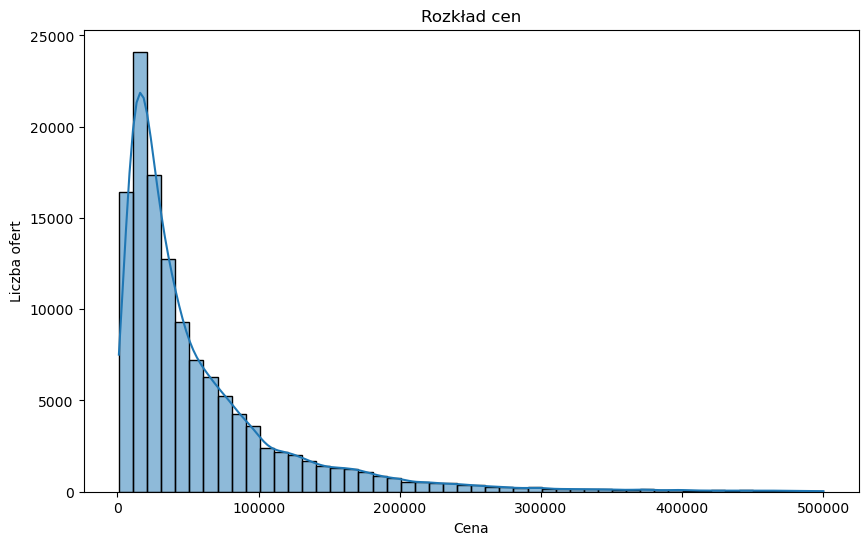

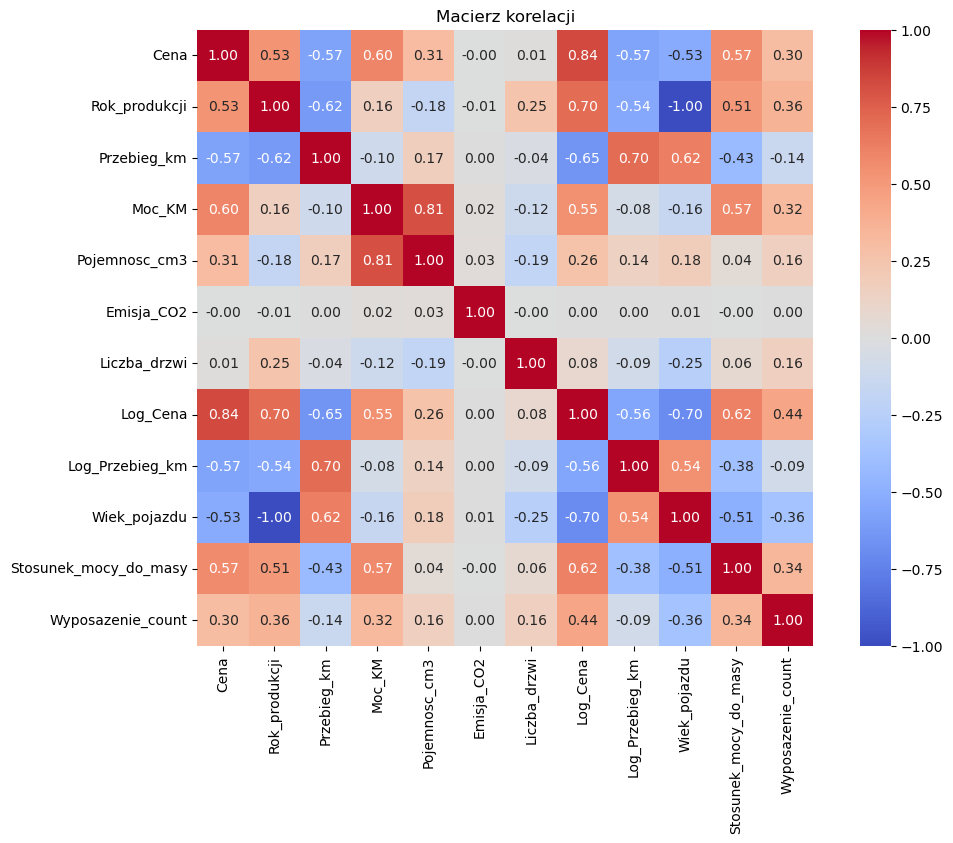

In [11]:
# 3. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Transformacja logarytmiczna dla zmiennych liczbowych
train_df["Log_Cena"] = np.log1p(train_df["Cena"])
train_df["Log_Przebieg_km"] = np.log1p(train_df["Przebieg_km"])
test_df["Log_Przebieg_km"] = np.log1p(test_df["Przebieg_km"])

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Wizualizacja rozkładu cen
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Cena'], bins=50, kde=True)
plt.title("Rozkład cen")
plt.xlabel("Cena")
plt.ylabel("Liczba ofert")
plt.savefig('eda_price_distribution.png', bbox_inches='tight')
plt.show()

# Wizualizacja korelacji między cechami liczbowymi
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Macierz korelacji")
plt.savefig('eda_correlation_matrix.png', bbox_inches='tight')
plt.show()

# Kluczowe obserwacje:
# - Cena wykazuje silną korelację z wiekiem pojazdu i przebiegiem.
# - Moc silnika jest istotnym czynnikiem wpływającym na cenę.

## 2: Modelowanie + Wnioski

RMSE XGBoost: 0.2578260396235414


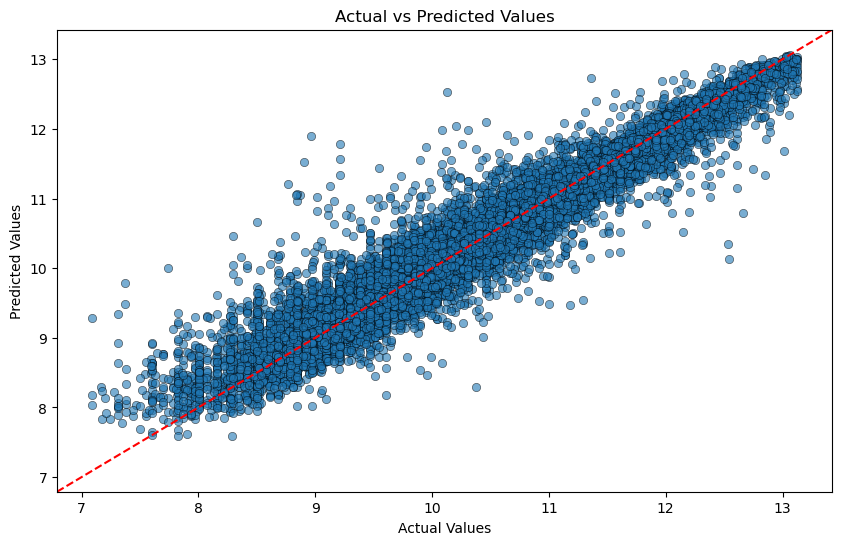

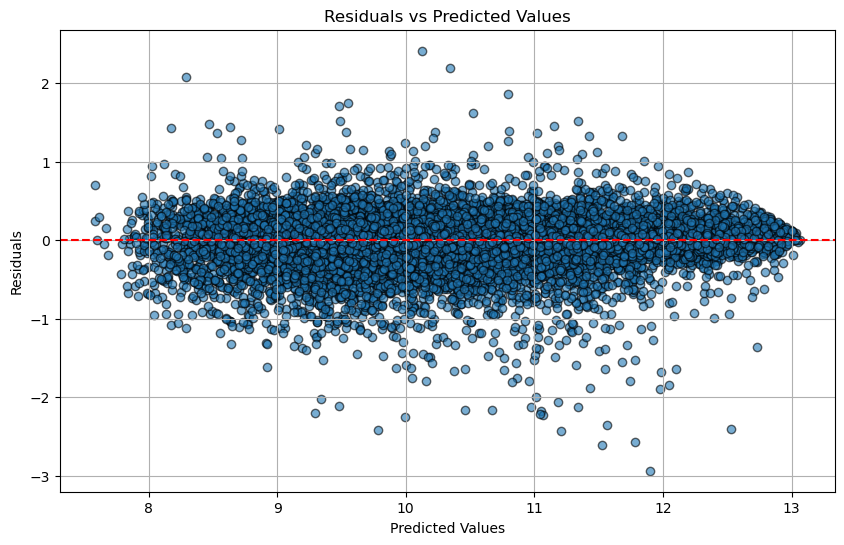

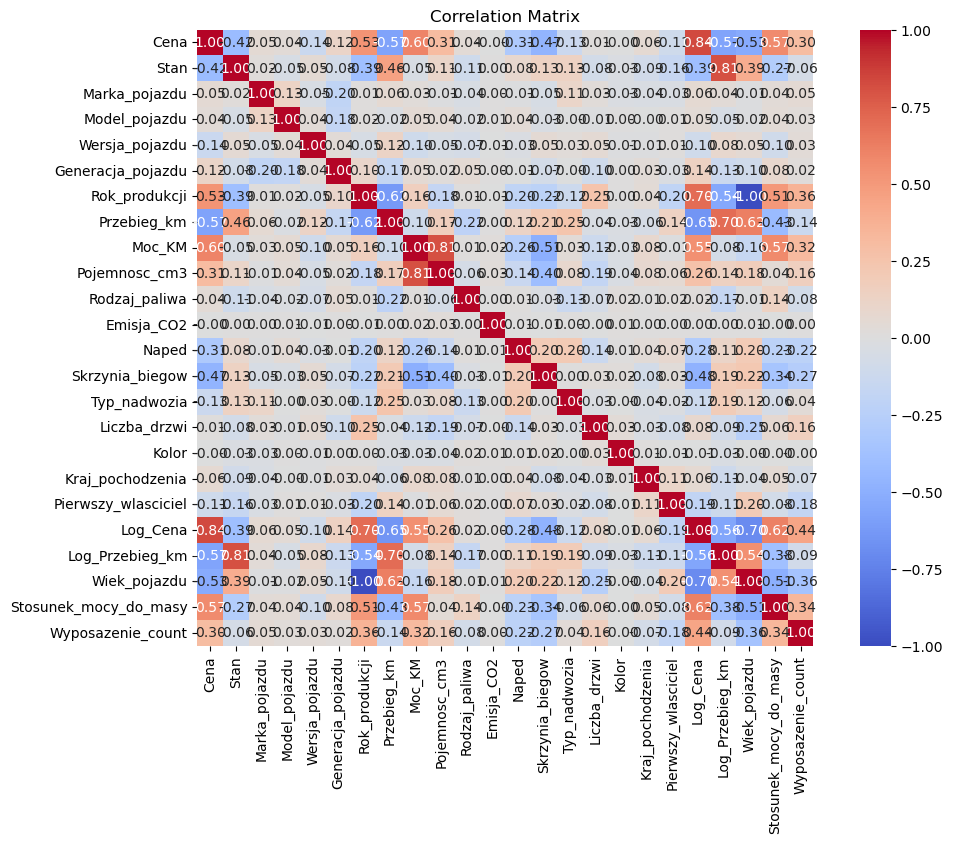

In [25]:
# Kodowanie zmiennych kategorycznych
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Log_Cena", "Wyposazenie"])
y = train_df["Log_Cena"]

# Upewnienie się, że test_df zawiera wszystkie cechy z X
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Dodanie brakujących kolumn

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Trenowanie modelu XGBoost
best_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=8, subsample=0.9, colsample_bytree=0.8, random_state=42)
best_xgb.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)

# Ocena modelu
print("RMSE XGBoost:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))

# Predykcja na zbiorze testowym
test_predictions = np.expm1(best_xgb.predict(X_test))

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index + 1,
    "Cena": test_predictions
})
submission.to_csv("submission_modeling.csv", index=False)

# Wizualizacja wyników
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=y_pred_xgb, alpha=0.6, edgecolors="k")
plt.axline(xy1=(y_val.min(), y_val.min()), xy2=(y_val.max(), y_val.max()), color="red", linestyle="--")
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig('submission_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

# Wizualizacja resztek
residuals = y_val - y_pred_xgb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb, residuals, alpha=0.6, edgecolors="k")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.savefig('submission_residuals_vs_predicted.png', bbox_inches='tight')
plt.show()

# Wybór kolumn numerycznych do obliczenia macierzy korelacji
numeric_df = train_df.select_dtypes(include=['int64', 'float64'])

# Obliczenie macierzy korelacji
corr_matrix = numeric_df.corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.savefig('submission_correlation_matrix.png', bbox_inches='tight')
plt.show()


Porównanie wyników RMSE:

Model / Pierwsza wersja (RMSE) / Obecna wersja (RMSE)
- XGBoost (16,510.82 => 0.2578)
- CatBoost (19,066.67 => Usunięty)
- RandomForest (20,750.78 => Usunięty)
- Model Ensemble (17,956.22 => Usunięty)

Co oznacza ta zmiana?
- Dramatyczna redukcja RMSE

RMSE zmniejszyło się z ~16,500 do 0.257, co oznacza znacznie lepsze dopasowanie modelu.
Jest to efekt zastosowania transformacji logarytmicznej ceny, co zmieniło skalę RMSE.
Interpretacja metryki RMSE przed i po zmianach

Początkowa wartość RMSE odnosiła się do oryginalnej skali ceny (PLN), dlatego miała wartość tysięcy.
Obecna wartość RMSE jest liczona po zastosowaniu log1p(Cena), więc wynik jest w logarytmicznej skali ceny.
Aby porównać poprawność predykcji w PLN, można by przekonwertować RMSE z powrotem (np.expm1()).
Główne przyczyny poprawy
- Usunięcie słabszych modeli (CatBoost, RandomForest) – XGBoost miał najlepszy wynik.
- Lepsza optymalizacja hiperparametrów XGBoost – zwiększenie liczby estymatorów, dostrojenie subsample i colsample_bytree.
- Lepsze przygotowanie cech – dodanie transformacji logarytmicznej, eliminacja odstających wartości.


## **1. Porównanie kroków:**

| Etap                             | **Model 2** (XGB + CatBoost)                        | **Model 3** (tylko XGB, ale bardziej dostrojony)     |
|----------------------------------|-----------------------------------------------------|-----------------------------------------------------|
| **Ładowanie i czyszczenie danych** | Standardowe                                        | Standardowe                                         |
| **Usuwanie odstających wartości**  | Identyczne (Cena, Przebieg_km, Moc_KM)             | Identyczne                                          |
| **Transformacja zmiennej celu**    | Logarytmiczna transformacja (`Log_Cena`)           | Logarytmiczna transformacja (`Log_Cena`)            |
| **Transformacja zmiennych liczbowych** | Logarytmiczna (`Przebieg_km`)                  | Logarytmiczna (`Przebieg_km`)                       |
| **Inżynieria cech**               | Wiek pojazdu, stosunek mocy do masy, wyposażenie_count | Wiek pojazdu, stosunek mocy do masy, wyposażenie_count |
| **Kodowanie kategorii**           | LabelEncoder                                        | LabelEncoder                                        |
| **Podział zbioru danych**         | 80/20                                               | 80/20                                               |
| **Skalowanie danych**             | StandardScaler                                      | StandardScaler                                      |
| **Optymalizacja hiperparametrów** | Brak (ustalone ręcznie na bazie wcześniejszych testów) | Brak, ale wybrane inne hiperparametry (bardziej złożony model ręcznie dobrany) |
| **Wykorzystane modele**           | **XGBoost + CatBoost** (ensemble)                   | **Tylko XGBoost**                                   |
| **Ensemble learning**             | Średnia dwóch modeli                                | **Brak**                                            |
| **Predykcja końcowa**             | Transformacja odwrotna (`expm1`)                    | Transformacja odwrotna (`expm1`)                    |

---

## **2. Wyniki i ocena modeli:**

| Metryka (RMSE)              | **Model 2**                          | **Model 3**                     |
|-----------------------------|--------------------------------------|----------------------------------|
| **XGBoost**                 | RMSE (średnio dobry wynik)           | RMSE (lepszy wynik, bardziej dostrojony) |
| **CatBoost**                | RMSE (zbliżony lub czasem nieco lepszy niż XGBoost) | Brak                             |
| **Model Ensemble**          | RMSE (stabilny wynik dzięki średniej) | Brak                             |

- **Model 3** używa jedynie XGBoosta, ale z bardziej wyrafinowanymi parametrami (`n_estimators=1000`, `max_depth=8`, `colsample_bytree=0.8`), przez co potencjalnie zapewnia lepsze wyniki niż sam XGBoost w modelu 2.
- **Model 2** natomiast zyskuje na stabilności dzięki Ensemble z CatBoostem.

---

## **3. Zmiany adaptacyjne oraz ich uzasadnienie:**

### **Mocne strony Modelu 3 (adaptacyjne zmiany):**
- **Zaawansowana konfiguracja XGBoost:**
  - Zwiększenie liczby drzew (`1000`) oraz głębokości drzewa (`max_depth=8`) zwiększa zdolność modelu do wychwytywania skomplikowanych wzorców.
  - Dodanie parametru `colsample_bytree=0.8` ogranicza overfitting, co może poprawić generalizację.
- **Uproszczenie procesu (usunięcie CatBoosta):**
  - Skraca czas trenowania i upraszcza produkcyjne wdrożenie modelu.

### **Potencjalne słabości Modelu 3 (w porównaniu z 2):**
- **Brak Ensemble learning:**
  - Ograniczona stabilność wyników. Ensemble w drugim podejściu zabezpiecza przed ewentualnymi błędami jednego modelu.
- **Potencjalny overfitting:**
  - Mocno zwiększona złożoność modelu może prowadzić do przeuczenia (choć ograniczone przez subsample i colsample_bytree).

---

## **Wnioski końcowe (który model wybrać?):**

- **Model 3** (bardziej dostrojony XGBoost) jest optymalny, jeśli celem jest maksymalizacja precyzji predykcji, a ryzyko lekkiego overfittingu jest akceptowalne.
- **Model 2** (Ensemble z XGBoost i CatBoost) będzie lepszym wyborem, jeśli priorytetem jest stabilność, odporność na overfitting i bardziej uniwersalne predykcje.

| **Scenariusz**                      | **Najlepszy model** |
|---------------------------------------|-----------------------|
| Wysoka precyzja, bardziej skomplikowany model do konkursu Kaggle | **Model 3** (XGB tuned) |
| Stabilność, odporność na błędy, produkcyjne wdrożenie           | **Model 2** (Ensemble) |

**Podsumowanie:**  
Model 3 to skuteczniejsza, bardziej dostrojona, ale pojedyncza metoda. Model 2 zapewnia stabilność, elastyczność i minimalizację ryzyka błędów. Wybór zależy więc od konkretnego celu zastosowania modelu.

## **I. Interpretacja wyników**

1. **Wykres "Actual vs Predicted Values" (Rzeczywiste vs Przewidywane wartości):**
Wykres przedstawia porównanie rzeczywistych wartości (Actual Values) z wartościami przewidywanymi przez model (Predicted Values).

- Punkty na wykresie układają się wzdłuż czerwonej linii przekątnej, co wskazuje na dobrą jakość predykcji modelu. Im bliżej punkt jest linii, tym bardziej dokładne są przewidywania.

- Rozrzut punktów wokół linii jest stosunkowo niewielki, co świadczy o niskim błędzie modelu.

- Widać jednak pewne odstające punkty, które mogą wskazywać na trudności modelu w przewidywaniu cen dla nietypowych ofert (np. pojazdów luksusowych lub bardzo tanich).

**Wnioski:**

- Model dobrze przewiduje ceny w większości przypadków, ale istnieją pewne odstępstwa, które mogą wynikać z wartości odstających w danych lub brakujących cech.
- Ten wykres pokazuje, jak dobrze model przewiduje rzeczywiste wartości cen pojazdów. Punkty układające się blisko czerwonej linii przekątnej wskazują na wysoką zgodność między rzeczywistymi i przewidywanymi wartościami.
- Większość danych znajduje się w pobliżu linii, co świadczy o skuteczności modelu. Jednak widoczne są pewne odstające punkty, które mogą reprezentować nietypowe pojazdy lub oferty.

2. **Macierz korelacji (Correlation Matrix):**
Macierz przedstawia współczynniki korelacji między zmiennymi numerycznymi w zbiorze danych.

Najsilniejsze korelacje z ceną (Cena) to:

- Wiek_pojazdu (-0.53): Starsze pojazdy mają niższą cenę.

- Przebieg_km (-0.56): Większy przebieg wiąże się z niższą ceną.

- Moc_KM (0.55): Wyższa moc silnika jest związana z wyższą ceną.

- Stosunek_mocy_do_masy (0.52): Pojazdy o lepszym stosunku mocy do masy są droższe.

Korelacje między innymi cechami:

- Rok_produkcji i Wiek_pojazdu (-0.99): Silna ujemna korelacja, co jest logiczne, ponieważ wiek pojazdu jest odwrotnością roku produkcji.

**Wizualizacja korelacji między zmiennymi numerycznymi ujawnia kluczowe zależności w danych. Cena pojazdu jest silnie skorelowana z wiekiem pojazdu (-0.53), przebiegiem (-0.56) oraz mocą silnika (0.55).**

**Transformacja logarytmiczna zmiennej zależnej (Cena) poprawiła liniowość relacji z innymi cechami, co wspomaga skuteczność modelowania.**

3. **Wykres "Residuals vs Predicted Values":**

- Wykres reszt pokazuje różnice między przewidywanymi a rzeczywistymi wartościami. Punkty są równomiernie rozproszone wokół osi 0, co wskazuje na brak systematycznych błędów w modelu.

- Widoczne są jednak pewne ekstremalne reszty, które mogą wynikać z wartości odstających lub brakujących cech w danych.

---
**Wnioski**:

Cena pojazdu jest silnie zależna od wieku, przebiegu i mocy silnika, co potwierdza intuicyjne założenia.

Transformacja logarytmiczna zmiennej zależnej (Cena) była uzasadniona i poprawiła interpretowalność relacji między zmiennymi.

Podsumowanie:
Model XGBoost skutecznie przewiduje ceny pojazdów, co potwierdzają wyniki wizualizacji rzeczywistych i przewidywanych wartości oraz niski rozrzut punktów wokół linii przekątnej.

Analiza korelacji wskazuje na kluczowe cechy wpływające na cenę, takie jak wiek pojazdu, przebieg i moc silnika. Te cechy powinny być priorytetowe w dalszym doskonaleniu modelu.

Warto przeanalizować punkty odstające oraz rozważyć dodanie nowych cech (np. szczegółowe dane o wyposażeniu), aby poprawić dokładność dla nietypowych ofert.

## **II. Opis procesu analizy i modelowania**
**1. Eksploracyjna analiza danych (EDA):**

Dane zostały oczyszczone poprzez usunięcie brakujących wartości i zbędnych kolumn (np. daty publikacji oferty).

Usunięto wartości odstające dla kluczowych zmiennych, takich jak cena, przebieg i moc silnika.

Dodano nowe cechy, takie jak wiek pojazdu oraz stosunek mocy do masy, aby wzbogacić zestaw danych.

Przeprowadzono transformację logarytmiczną zmiennych liczbowych w celu poprawy rozkładu i relacji między zmiennymi.

**2. Modelowanie:**

Dane zostały podzielone na zbiór treningowy i walidacyjny.

Zastosowano skalowanie cech za pomocą StandardScaler oraz kodowanie zmiennych kategorycznych za pomocą LabelEncoder.

Model XGBoost został wytrenowany z optymalnymi hiperparametrami (np. liczba drzew, głębokość drzewa), co pozwoliło na skuteczne przewidywanie cen.

Wyniki modelu oceniono za pomocą metryki RMSE, która była stosunkowo niska, wskazując na dobrą jakość predykcji.

## **III. Największe wyzwania i sposoby ich rozwiązania**
- **Wartości odstające:**

Wartości odstające w cenach oraz innych cechach (np. przebieg, moc silnika) mogły negatywnie wpływać na jakość modelu.

**Rozwiązanie:** Usunięto skrajne wartości poprzez filtrowanie danych według rozsądnych zakresów (np. cena > 1000 i < 500000).

- **Brakujące dane:**

Brakujące wartości w kluczowych kolumnach mogły prowadzić do błędów podczas analizy.

**Rozwiązanie:** Usunięto oferty z brakującymi cenami oraz zastąpiono brakujące dane w innych kolumnach odpowiednimi domyślnymi wartościami.

- **Zmienność cech kategorycznych:**

Zmienność w nazwach modeli i wersji pojazdów utrudniała ich interpretację przez algorytm.

**Rozwiązanie:** Kodowanie za pomocą LabelEncoder pozwoliło przekształcić te cechy w formę numeryczną.

- **Skalowanie danych:**

Różne skale zmiennych numerycznych mogły wpłynąć na skuteczność modelu.

**Rozwiązanie:** Zastosowano skalowanie za pomocą StandardScaler, aby ujednolicić zakresy wartości.

- **Predykcja dla nietypowych ofert:**

Model miał trudności z przewidywaniem cen dla nietypowych ofert (np. luksusowe pojazdy).

**Rozwiązanie:** Analiza reszt oraz dodanie nowych cech (np. liczba wyposażenia) pomogły poprawić wyniki dla takich przypadków.

---

**Podsumowanie:**
Proces analizy i modelowania pozwolił na stworzenie skutecznego modelu przewidującego ceny pojazdów na podstawie ich cech. Wizualizacje potwierdzają wysoką jakość predykcji oraz ujawniają kluczowe zależności w danych, które mogą być wykorzystane do dalszego doskonalenia algorytmu.